[INFO] file: ../../output_root/v3_production/samples/postEE/GJetPt40.parquet
[INFO] xsec=1.0 pb, lumi=1.0 fb^-1 -> norm_factor = xsec*lumi (pb^-1) = 1.000000e+03
[SAVED] overlay_plots_postEE/GJetPt40.parquet__Res_lead_bjet_btagPNetB__overlay.png


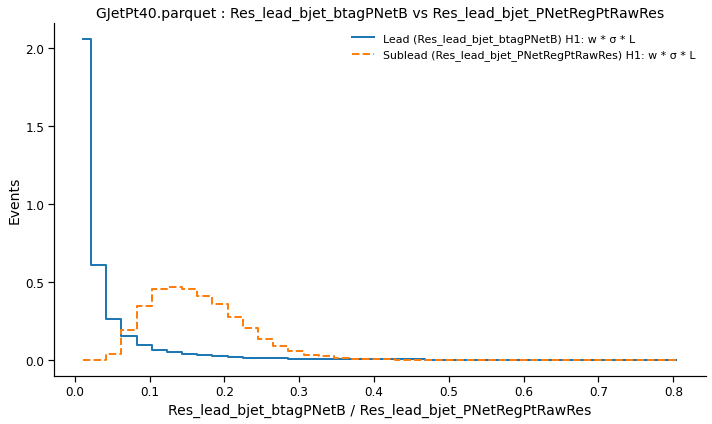

[SAVED] overlay_plots_postEE/GJetPt40.parquet__Res_sublead_bjet_btagPNetB__overlay.png


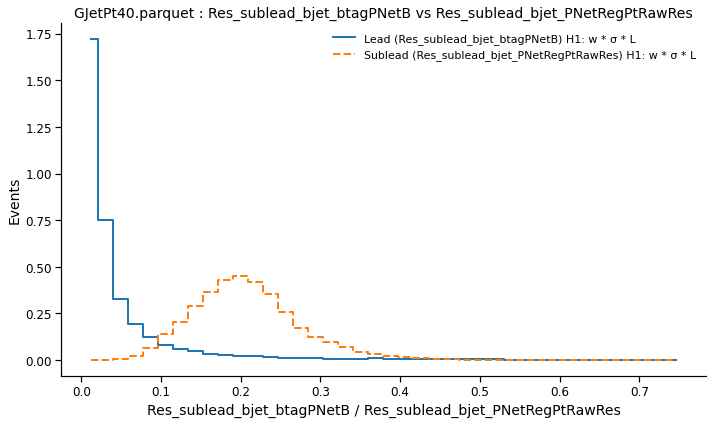

In [4]:
# === overlay_bjet_vars.py (notebook-friendly) ===
import os, sys
import numpy as np
import awkward as ak
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

# --- set repo path (adjust if needed) ---
repo_path = os.path.abspath("../../output_root/v3_production/samples/postEE")
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

# import getXsec/getLumi from your normalisation module
try:
    from normalisation import getXsec, getLumi
except Exception:
    # fallback stubs just in case — replace with real module in production
    def getXsec(_): return 1.0
    def getLumi(year, era): return 1.0

# clean plotting helper (CMS-like)
def clean_axis(ax, fontsize=12):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)
    ax.tick_params(axis="both", which="major", length=6, width=1.2, labelsize=fontsize)
    ax.set_facecolor("white")
    ax.grid(False)

# function to build histograms and plot overlay
def overlay_bjet_vars(parquet_path,
                      vars_pairs=[
                          ("Res_lead_bjet_btagPNetB", "Res_sublead_bjet_btagPNetB"),
                          ("Res_lead_bjet_PNetRegPtRawRes", "Res_sublead_bjet_PNetRegPtRawRes"),
                      ],
                      nbins=60, ranges=None,
                      year="2023", era="postEE",
                      out_dir="overlay_plots",
                      logy=False,
                      show_h2=True):
    """
    Produce overlay plots for pairs of variables (lead, sublead).
    - parquet_path: path to single parquet file (string)
    - vars_pairs: list of (lead_var, sublead_var) pairs
    - ranges: dict mapping varname -> (lo, hi). If None, auto-range from data.
    - show_h2: if True, also draw H2 = (weight/weight_central)*xsec*lumi for comparison.
    """

    os.makedirs(out_dir, exist_ok=True)
    pqf = pq.ParquetFile(parquet_path)
    available = set(pqf.schema.names)

    # required columns
    needed = set()
    for a,b in vars_pairs:
        needed.add(a); needed.add(b)
    needed.update(["weight", "weight_central"])
    missing = [c for c in needed if c not in available]
    if missing:
        raise RuntimeError(f"Missing columns in file: {missing}")

    # read arrays (batch loop to limit memory)
    vals_store = {v: [] for v in needed}
    for batch in pqf.iter_batches(batch_size=200000, columns=list(needed)):
        arr = ak.from_arrow(batch)
        for v in needed:
            vals = ak.to_numpy(arr[v]) if v in arr.fields else np.array([],dtype=float)
            vals_store[v].append(vals)

    # concat
    for k in list(vals_store.keys()):
        if len(vals_store[k]) == 0:
            vals_store[k] = np.array([], dtype=float)
        else:
            vals_store[k] = np.concatenate(vals_store[k])

    # basic sanitization / masks
    weights = np.where(np.isfinite(vals_store["weight"]), vals_store["weight"], 0.0)
    wc = np.where(np.isfinite(vals_store["weight_central"]), vals_store["weight_central"], np.nan)

    # xsec + lumi
    xsec = float(getXsec(parquet_path))
    lumi_fb = float(getLumi(year, era))
    lumi_pb = lumi_fb * 1000.0
    norm_factor = xsec * lumi_pb

    print(f"[INFO] file: {parquet_path}")
    print(f"[INFO] xsec={xsec} pb, lumi={lumi_fb} fb^-1 -> norm_factor = xsec*lumi (pb^-1) = {norm_factor:.6e}")

    # Loop pairs and make plots
    for lead_var, sub_var in vars_pairs:
        lead_vals = vals_store[lead_var]
        sub_vals  = vals_store[sub_var]

        # determine plotting range
        if ranges and lead_var in ranges:
            lo, hi = ranges[lead_var]
        elif ranges and sub_var in ranges:
            lo, hi = ranges[sub_var]
        else:
            # choose combined auto-range (ignore extreme outliers)
            comb = np.concatenate([lead_vals[np.isfinite(lead_vals)], sub_vals[np.isfinite(sub_vals)]])
            if comb.size == 0:
                lo, hi = 0.0, 1.0
            else:
                lo = np.percentile(comb, 0.5)
                hi = np.percentile(comb, 99.5)
                if lo == hi:
                    lo -= 0.5; hi += 0.5

        edges = np.linspace(lo, hi, nbins+1)
        centers = 0.5*(edges[1:]+edges[:-1])

        # build histograms H1 and H2 for lead
        mask_lead = np.isfinite(lead_vals)
        h1_lead, _ = np.histogram(lead_vals[mask_lead], bins=edges, weights=weights[mask_lead] * norm_factor)
        wc_safe = np.where(wc==0, np.nan, wc)
        w_ratio_lead = np.where(np.isfinite(weights[mask_lead] / wc_safe[mask_lead]), weights[mask_lead] / wc_safe[mask_lead], 0.0)
        h2_lead, _ = np.histogram(lead_vals[mask_lead], bins=edges, weights=w_ratio_lead * norm_factor)

        # build histograms H1 and H2 for sublead
        mask_sub = np.isfinite(sub_vals)
        h1_sub, _ = np.histogram(sub_vals[mask_sub], bins=edges, weights=weights[mask_sub] * norm_factor)
        w_ratio_sub = np.where(np.isfinite(weights[mask_sub] / wc_safe[mask_sub]), weights[mask_sub] / wc_safe[mask_sub], 0.0)
        h2_sub, _ = np.histogram(sub_vals[mask_sub], bins=edges, weights=w_ratio_sub * norm_factor)

        # normalize option (uncomment to compare shapes with unit area)
        # h1_lead_n = h1_lead / h1_lead.sum() if h1_lead.sum()>0 else h1_lead
        # h1_sub_n  = h1_sub  / h1_sub.sum()  if h1_sub.sum()>0 else h1_sub

        # PLOT: lead vs sublead (H1 only) with optional H2 overlays
        fig, ax = plt.subplots(figsize=(10,6))

        ax.step(centers, h1_lead, where="mid", label=f"Lead ({lead_var}) H1: w * σ * L", linewidth=2)
        ax.step(centers, h1_sub,  where="mid", label=f"Sublead ({sub_var}) H1: w * σ * L", linewidth=2, linestyle="--")

        if show_h2:
            ax.step(centers, h2_lead, where="mid", label=f"Lead H2: w/wc * σ * L", linewidth=1.5, alpha=0.8)
            ax.step(centers, h2_sub,  where="mid", label=f"Sublead H2: w/wc * σ * L", linewidth=1.5, alpha=0.8, linestyle="--")

        ax.set_xlabel(f"{lead_var} / {sub_var}", fontsize=14)
        ax.set_ylabel("Events", fontsize=14)
        ax.set_title(f"{os.path.basename(parquet_path)} : {lead_var} vs {sub_var}", fontsize=14)

        clean_axis(ax, fontsize=12)
        ax.legend(frameon=False, fontsize=11, loc="upper right")

        if logy:
            ax.set_yscale("log")
            # set a small positive bottom to avoid log(0) issues
            ymin = max(1e-2, np.nanmin(np.concatenate([h1_lead[h1_lead>0] if h1_lead.sum()>0 else [1e-2,
                                                                              ], 
                                                                             h1_sub[h1_sub>0] if h1_sub.sum()>0 else [1e-2]])))
            ax.set_ylim(bottom=ymin)

        plt.tight_layout()

        outname = os.path.join(out_dir, f"{os.path.basename(parquet_path)}__{lead_var}__overlay.png")
        plt.savefig(outname, dpi=150)
        print(f"[SAVED] {outname}")
        plt.show()
        plt.close(fig)

# === Example usage ===
parquet_file = "../../output_root/v3_production/samples/postEE/GJetPt40.parquet"
overlay_bjet_vars(
    parquet_file,
    vars_pairs=[
        ("Res_lead_bjet_btagPNetB", "Res_lead_bjet_PNetRegPtRawRes"),
        ("Res_sublead_bjet_btagPNetB", "Res_sublead_bjet_PNetRegPtRawRes"),
    ],
    nbins=40,
    ranges=None,   # or pass {'Res_lead_bjet_PNetRegPtRawRes': (0,500), ...}
    year="2023",
    era="postEE",
    out_dir="overlay_plots_postEE",
    logy=False,
    show_h2=False  # set True to draw H2 overlays as well
)
